In [2]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import NearestNeighbors


In [3]:
data = pd.read_csv("penguins.csv")


In [4]:
cleaned_data = data.select_dtypes(include=["number"])


In [5]:
imputer = SimpleImputer(strategy="mean")
data_imputed = pd.DataFrame(imputer.fit_transform(cleaned_data), columns=cleaned_data.columns)


In [7]:
scaler = StandardScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data_imputed), columns=data_imputed.columns)


In [8]:
data_normalized.to_csv("Preprocessed_Penguins.csv", index=False)
print("Preprocessing completed. Preprocessed data saved to 'Preprocessed_Penguins.csv'.")


Preprocessing completed. Preprocessed data saved to 'Preprocessed_Penguins.csv'.


In [9]:
inertia = []
silhouette_scores_kmeans = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans_labels = kmeans.fit_predict(data_normalized)
    inertia.append(kmeans.inertia_)
    silhouette_scores_kmeans.append(silhouette_score(data_normalized, kmeans_labels))


Text(0, 0.5, 'Inertia')

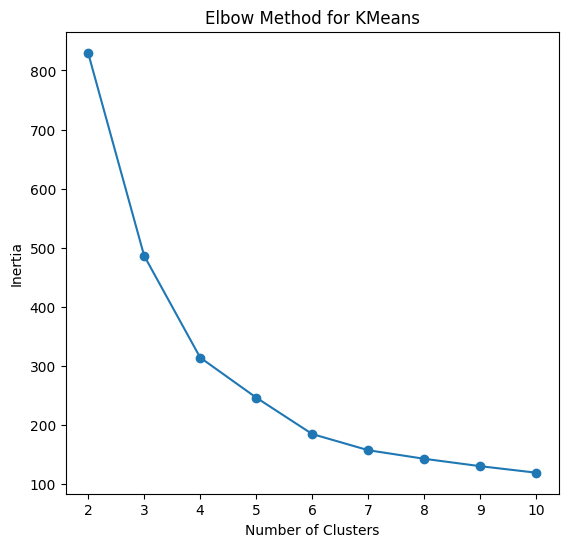

In [10]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

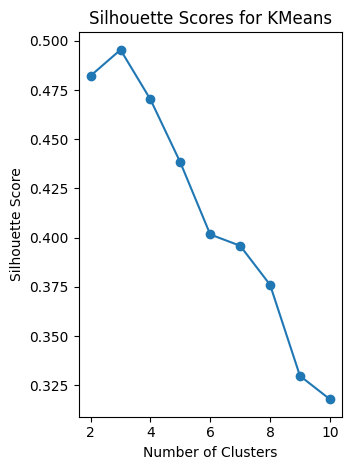

In [11]:
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores_kmeans, marker='o')
plt.title('Silhouette Scores for KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()


In [12]:
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(data_normalized)
kmeans_silhouette = silhouette_score(data_normalized, kmeans_labels)
print(f"KMeans Silhouette Score: {kmeans_silhouette:.4f}")


KMeans Silhouette Score: 0.4954


In [35]:
dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan_labels = dbscan.fit_predict(data_normalized)


In [36]:
if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(data_normalized[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
else:
    dbscan_silhouette = -1
print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.4f}")


DBSCAN Silhouette Score: 0.7945


In [39]:
n_clusters = 3
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(data_normalized)
gmm_silhouette = silhouette_score(data_normalized, gmm_labels)
print(f"GMM Silhouette Score: {gmm_silhouette:.4f}")


GMM Silhouette Score: 0.4959


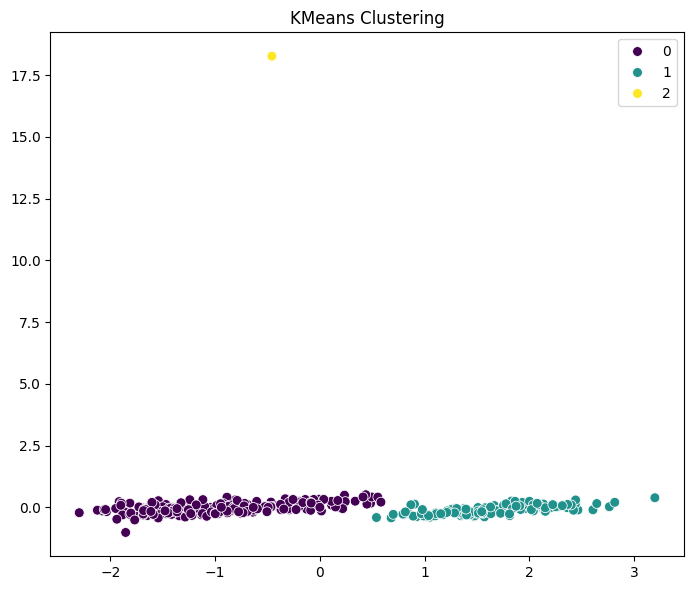

In [20]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_normalized)

plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=kmeans_labels, palette='viridis', s=50)
plt.title("KMeans Clustering")

plt.tight_layout()
plt.show()


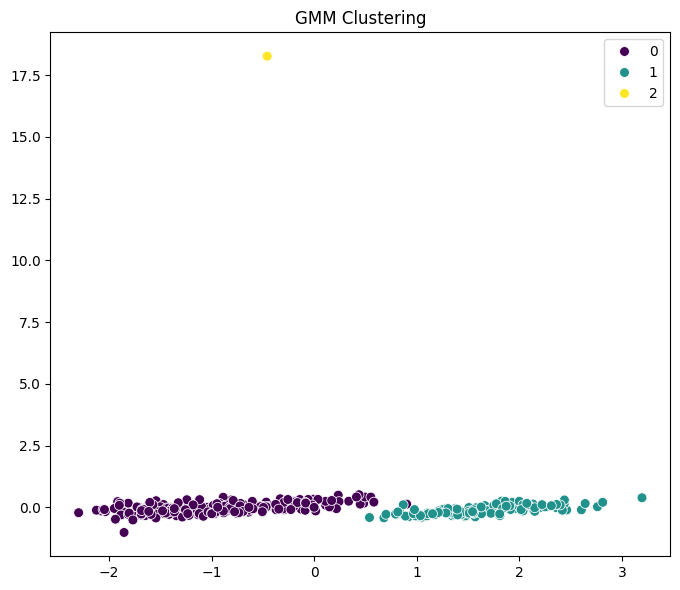

In [27]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_normalized)
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 3)
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=gmm_labels, palette='viridis', s=50)
plt.title("GMM Clustering")

plt.tight_layout()
plt.show()

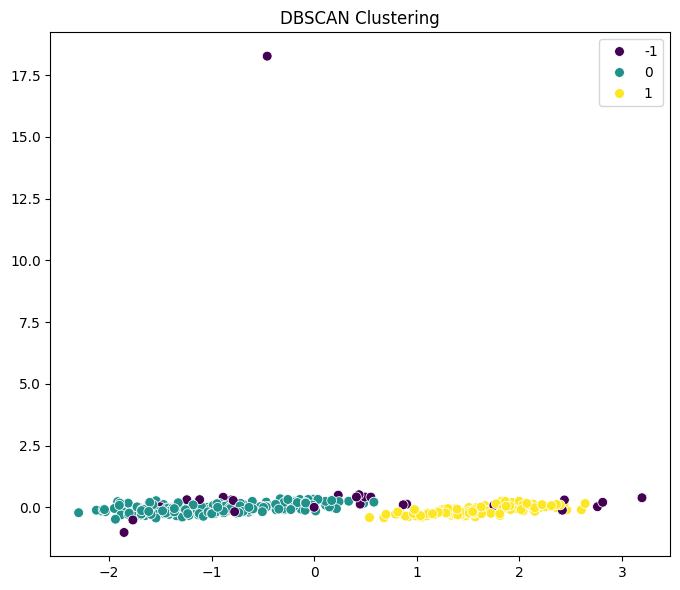

In [28]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_normalized)
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 2)
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=dbscan_labels, palette='viridis', s=50)
plt.title("DBSCAN Clustering")

plt.tight_layout()
plt.show()

In [17]:
if kmeans_silhouette > max(dbscan_silhouette, gmm_silhouette):
    print("KMeans is recommended.")
elif gmm_silhouette > max(kmeans_silhouette, dbscan_silhouette):
    print("GMM is recommended.")
else:
    print("DBSCAN is recommended.")


DBSCAN is recommended.


In [34]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def predict_new_point(new_data, scaler, kmeans, dbscan, gmm, data_normalized, feature_names):
    """
    Predict the cluster assignment for a new data point using KMeans, DBSCAN, and GMM models.
    
    Args:
        new_data (list): List of values for the new data point (same features as training data).
        scaler (object): Fitted StandardScaler for data normalization.
        kmeans (object): Fitted KMeans model.
        dbscan (object): Fitted DBSCAN model.
        gmm (object): Fitted GMM model.
        data_normalized (DataFrame): The normalized training dataset for DBSCAN neighbors.
        feature_names (list): List of feature names from the original dataset.

    Returns:
        None. Prints the cluster assignments for each algorithm.
    """
    # Convert the new data point into a DataFrame with feature names
    new_data_df = pd.DataFrame([new_data], columns=feature_names)
    
    # Scale the new data point
    new_data_scaled = scaler.transform(new_data_df)

    # KMeans Prediction
    kmeans_cluster = kmeans.predict(new_data_scaled)
    print(f"KMeans: The new data point belongs to cluster {kmeans_cluster[0]}")

    # DBSCAN Prediction (using Nearest Neighbors)
    neighbors = NearestNeighbors(radius=dbscan.eps).fit(data_normalized)
    distances, indices = neighbors.radius_neighbors(new_data_scaled)

    if len(indices[0]) > 0:
        print(f"DBSCAN: The new data point belongs to a cluster (neighbor points: {indices[0]}).")
    else:
        print("DBSCAN: The new data point is considered noise (label -1).")

    # GMM Prediction
    gmm_cluster = gmm.predict(new_data_scaled)
    print(f"GMM: The new data point belongs to cluster {gmm_cluster[0]}")


# Example new data point
new_data = [0.5, -1.2, 1.3, 0.7]  # Replace these values with actual feature values

# Extract feature names from the original preprocessed data
feature_names = data_normalized.columns.tolist()

# Call the function
predict_new_point(new_data, scaler, kmeans, dbscan, gmm, data_normalized, feature_names)



KMeans: The new data point belongs to cluster 0
DBSCAN: The new data point is considered noise (label -1).
GMM: The new data point belongs to cluster 0


c:\Users\mmeln\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
c:\Users\mmeln\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
c:\Users\mmeln\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
